In [29]:
import pandas as pd
import tensorflow as tf

In [30]:
bike_rentals = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")
bike_rentals_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv")

In [31]:
bike_rentals["total"] = bike_rentals.casual + bike_rentals.registered

In [32]:
bike_rentals.head()
# bike_rentals_holdout.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered,total
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13,16
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32,40
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27,32
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10,13
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1,1


In [33]:
x = bike_rentals.drop(["casual", "registered", "total", "dteday"] , axis="columns")
y = bike_rentals.total

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [35]:
x_train.shape

(11645, 9)

In [36]:
minmax_scaler = preprocessing.MinMaxScaler()
x_train = minmax_scaler.fit_transform(x_train) # fit the scale to the training data
x_test = minmax_scaler.transform(x_test) # use the same scale on the testing data

In [37]:
from keras.models import Sequential
from keras.layers import Dense

# Initialize the Neural Network
model = Sequential() # Sequential just means the network doesn't have loops--the outputs of one layer of neurons go to the next layer of neurons

# Add the first layer


model.add(Dense(64, input_dim=9, activation='relu')) # This layer has 64 neurons. They are each connected (dense) to the input neurons.
# Note: We want the input dimension to match the number of features at our input layer

# Add "hidden layers"
model.add(Dense(32, activation = 'relu')) # This layer has 32 neurons

model.add(Dense(16, activation = 'relu'))

model.add(Dense(8, activation = 'relu'))

# Add the "output layer"
model.add(Dense(1, activation='linear')) # Our last layer doesn't need a non-linear activation function, unless it is useful for the type of answer we want
# The ouput layer should have the same number of neurons as outputs you are generating. In this case, it is just producing one number. 

# Compile model
model.compile(loss='MSE', optimizer= 'Adam', metrics=['mean_squared_error'])

In [38]:
# Train the model
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 400, verbose = 0)

In [39]:
# Evaluate the model on the training data
_, train_mse = model.evaluate(x_train, y_train, verbose = 1)

# Evaluate the model on the testing data
_, test_mse = model.evaluate(x_test, y_test, verbose = 1)

156/156 [==============================] - 0s 2ms/step - loss: 5374.7930 - mean_squared_error: 5374.7930


In [40]:
# Get predictions for the testing data
predictions = model.predict(x_test)

# Get the r^2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(r2)

156/156 [==============================] - 0s 1ms/step
0.8407470803249535


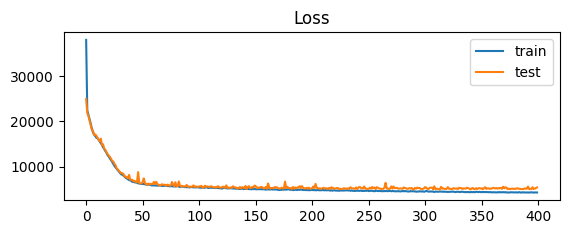

In [41]:
# Plot loss during training (we can do this because we saved a "history" during training)
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# pyplot.ylim(20000,23000)
# pyplot.xlim(0,100)

In [24]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [26]:
# We can make several different models, so let's make a function to make the model

# Function to create model, required for KerasClassifier / KerasRegressor
def create_model(optimizer='adam'):
	model = Sequential()
	model.add(Dense(64, input_dim=9, activation='relu'))
	model.add(Dense(1, activation='relu'))
	# Compile model
	model.compile(loss='MSE', optimizer=optimizer, metrics=['mse'])
	return model

# Let's use the KerasRegressor tool to make the model so that we can pass it to a hyperparameter grid search
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
batch_size = [16, 32]
epochs = [400, 40]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Run the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

<ipython-input-26-208227f8d37d>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -20919.766276 using {'batch_size': 16, 'epochs': 30}
-31976.003581 (26543.319242) with: {'batch_size': 16, 'epochs': 300}
-20919.766276 (497.976805) with: {'batch_size': 16, 'epochs': 30}
-32308.844727 (26311.065411) with: {'batch_size': 32, 'epochs': 300}
-21163.341797 (228.270693) with: {'batch_size': 32, 'epochs': 30}
